In [97]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt

In [98]:
data = pd.read_csv("Auto.csv")
data['origin'] = data['origin'].astype('category')

print(data.head())

    mpg  cylinders  displacement horsepower  weight  acceleration  year  \
0  18.0          8         307.0        130    3504          12.0    70   
1  15.0          8         350.0        165    3693          11.5    70   
2  18.0          8         318.0        150    3436          11.0    70   
3  16.0          8         304.0        150    3433          12.0    70   
4  17.0          8         302.0        140    3449          10.5    70   

  origin                       name  
0      1  chevrolet chevelle malibu  
1      1          buick skylark 320  
2      1         plymouth satellite  
3      1              amc rebel sst  
4      1                ford torino  


In [99]:
mean_horsepower = data['horsepower'].replace('?', np.nan).astype(float).mean()
data['horsepower'] = pd.to_numeric(data['horsepower'], errors='coerce').fillna(mean_horsepower)

In [100]:
train_data = data.sample(frac=0.8, random_state=1)
test_data = data.drop(train_data.index)

print(f"Training data size: {train_data.shape}")
print(f"Testing data size: {test_data.shape}")

Training data size: (318, 9)
Testing data size: (79, 9)


In [101]:
model = smf.ols('mpg ~ horsepower', data=train_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     463.6
Date:                Thu, 20 Nov 2025   Prob (F-statistic):           6.35e-64
Time:                        17:03:21   Log-Likelihood:                -969.94
No. Observations:                 318   AIC:                             1944.
Df Residuals:                     316   BIC:                             1951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.5379      0.827     49.009      0.0

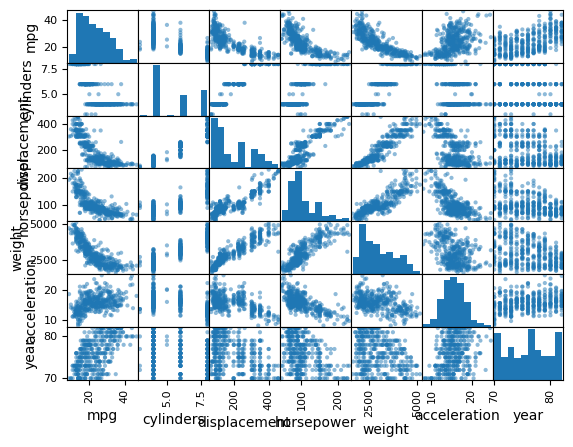

In [102]:
pd.plotting.scatter_matrix(data)
plt.show()

In [103]:
data.corr(numeric_only=True)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year
mpg,1.000000,-0.776260,-0.804443,-0.771441,-0.831739,0.422297,0.581469
cylinders,-0.776260,1.000000,0.950920,0.839715,0.897017,-0.504061,-0.346717
displacement,-0.804443,0.950920,1.000000,0.893833,0.933104,-0.544162,-0.369804
horsepower,-0.771441,0.839715,0.893833,1.000000,0.860581,-0.687039,-0.413022
weight,-0.831739,0.897017,0.933104,0.860581,1.000000,-0.419502,-0.307900
acceleration,0.422297,-0.504061,-0.544162,-0.687039,-0.419502,1.000000,0.282901
year,0.581469,-0.346717,-0.369804,-0.413022,-0.307900,0.282901,1.000000


In [104]:
model1 = smf.ols(
    "mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin",
    data=train_data
).fit()

model2 = smf.ols(
    "mpg ~ I(np.log(weight)) + I(np.log(horsepower)) + I(np.log(displacement)) + I(np.log(acceleration)) + I(np.sqrt(year)) + origin",
    data=train_data
).fit()

model3 = smf.ols(
    "mpg ~ I(np.log(weight)) * horsepower + I(np.log(acceleration)) + I(np.sqrt(year)) + origin",
    data=train_data
).fit()

models = [model1, model2, model3]

model_mse = [np.mean((test_data['mpg'] - m.predict(test_data)) ** 2) for m in models]
for i, mse in enumerate(model_mse, 1):
    print(f"Model {i}: {mse}")

best_model_index = np.argmin(model_mse)
best_model = models[best_model_index]
print(f"\nBest model on test data is Model {best_model_index + 1}\n")

Model 1: 9.912363771965646
Model 2: 8.571838127670173
Model 3: 8.315143734114228

Best model on test data is Model 3



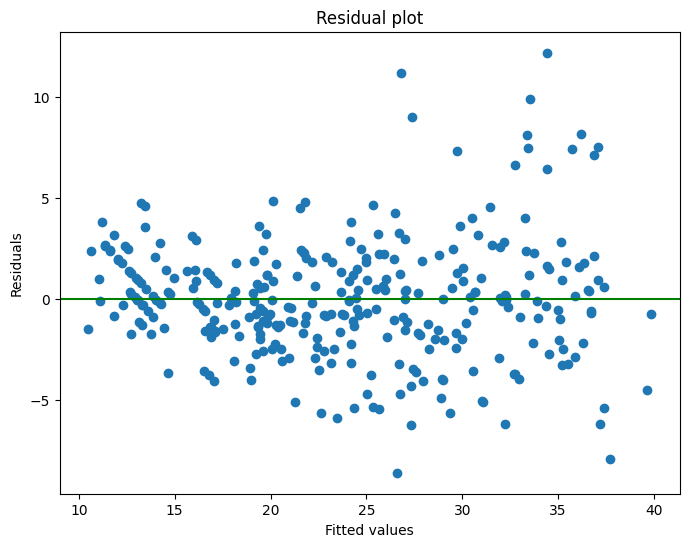

Number of outliers: 14
Number of high-leverage points: 16

Model after removing outliers and high-leverage points:
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     309.0
Date:                Thu, 20 Nov 2025   Prob (F-statistic):          2.04e-130
Time:                        17:03:22   Log-Likelihood:                -710.80
No. Observations:                 298   AIC:                             1438.
Df Residuals:                     290   BIC:                             1467.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975

In [105]:
train_data["resid"] = best_model.resid
train_data["leverage"] = best_model.get_influence().summary_frame()["hat_diag"]

plt.figure(figsize=(8,6))
plt.scatter(best_model.fittedvalues, best_model.resid)
plt.axhline(0, color="green")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual plot")
plt.show()

z_scores = np.abs(stats.zscore(train_data.select_dtypes(include=["number"]), nan_policy="omit"))
outliers = (z_scores > 3).any(axis=1)
high_leverage = train_data["leverage"] > 2 * np.mean(train_data["leverage"])

print(f"Number of outliers: {outliers.sum()}")
print(f"Number of high-leverage points: {high_leverage.sum()}")
points_to_remove = outliers | high_leverage
n_points_to_remove = points_to_remove.sum()

train_data = train_data.loc[~points_to_remove]

better_model = smf.ols(best_model.model.formula, data=train_data).fit()
print("\nModel after removing outliers and high-leverage points:")
print(better_model.summary())

better_model_mse = np.mean((test_data['mpg'] - better_model.predict(test_data)) ** 2)
print(f"Better model MSE on test data: {better_model_mse}")